In [ ]:
!pip install noisereduce
!pip -q install transformers
!pip install wordcloud
!pip install soundfile

In [ ]:
import librosa, torch, noisereduce, numpy, soundfile
from IPython.display import Javascript, display
import IPython
from google.colab import output
from base64 import b64decode
from wordcloud import WordCloud, STOPWORDS
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [ ]:
# Global Variable
sec = 20

# Helper Functions

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('inputaudio.wav','wb') as f:
    f.write(b)
  return 'inputaudio.wav'

def create_word_cloud(string):
    
   cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")

# DATA AQUISITION STEP

DATA EXTRACTION

In [ ]:
record(sec)
IPython.display.Audio('/content/inputaudio.wav')

<IPython.core.display.Javascript object>

Noise Reduction

In [ ]:
# Load data and calculate spectrogram magnitude as well as phase


data, sr = librosa.load('/content/inputaudio.wav')

data = noisereduce.reduce_noise(y=data,sr=sr)

# Noise Reduction Algorithm Workings:
# Calculate a spectrogram of the audio clip
# Calculate a threshold based on the statistic likelyhood of the noises in the audio file
# Calculate a spectrogram over the signal previousely generated
# Create a mask that is the difference between the threshold and the spectrogram.
# The mask is smoothed using a filter that is applied in the time frequency domain
# The mask is applied to the spectrogram of the signal and is inverted.

soundfile.write('pre.wav',data, sr)

IPython.display.Audio('/content/pre.wav')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FEATURE EXTRACTION & CLASSIFICATION

In [ ]:
# Initilize the model & tokenizer for wav2vec2 
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:423: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
audio, sr = librosa.load('/content/pre.wav',sr = 16000)

# tokenize the audio data so that it can be used in the model
input_values = tokenizer(audio, return_tensors = "pt").input_values

# store non-normalized predictions based on the logit function applied to the input values
logits = model(input_values).logits

# calculate the predicted transcription of the audio file.
prediction = torch.argmax(logits, dim = -1)

results = tokenizer.batch_decode(prediction)[0]


POST PROCESSING

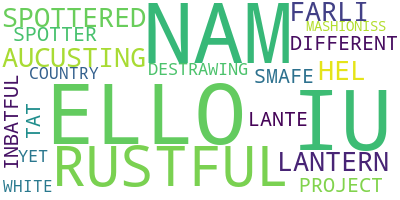

In [ ]:
create_word_cloud(filtered_results)
IPython.display.Image('/content/wordCloud.png')